<a href="https://www.kaggle.com/code/harshris21/dcgan-scratch-implement?scriptVersionId=127115435" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:

!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip
     

--2023-04-25 06:03:27--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2023-04-25 06:03:28--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2eebe0ecd1d758a1996e51c06f.dl.dropboxusercontent.com/cd/0/inline/B61yf0U-E2_w3bgbNc3atW6pZbFBuUGTAMwnhvGjkUHpsRh_sPRoHcY0tb1d9J3folgcFGIUq7PiMTG0x3rjE0Ue5jrtFQqwlyz2IT2ReVCdhhNCNS7XjXWvNIwe7bu1tHuZ9Y_SLZ1DXA2FVDKkDLwEr1c8YXbsekV6v5FHnf0tUw/file# [following]
--2023-04-25 06:03:28--  https://uc2eebe0ecd1d758a1996e51c06f.dl.dropboxusercontent.com/cd/0/inline/B61yf0U-E2_w3bgbNc3atW6pZbFBuUGTAMw

In [1]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [6]:
# !mkdir cropped_faces
images = Glob('/kaggle/working/females/*.jpg')+Glob('/kaggle/working/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
#         print(x,y,w,h)
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('/kaggle/working/cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

In [7]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     

In [8]:
class Faces(Dataset):
    def __init__(self,folder):
        self.images=sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self,ix):
        img_path=self.images[ix]
        image=Image.open(img_path)
        image=transform(image)
        return image

In [ ]:
s=Glob('/kaggle/working/cropped_faces/*.jpg')

In [ ]:
s

In [9]:
ds = Faces(folder='/kaggle/working/cropped_faces/')

In [10]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input): return self.model(input)

In [13]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self,input): return self.model(input)

In [15]:

generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

In [16]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [17]:

discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
     

EPOCH: 1.000  g_loss: 8.971  d_loss: 0.655  (36.42s - 874.16s remaining)))
EPOCH: 2.000  g_loss: 5.935  d_loss: 0.630  (71.95s - 827.46s remaining))
EPOCH: 3.000  g_loss: 4.781  d_loss: 0.555  (107.28s - 786.71s remaining)
EPOCH: 4.000  g_loss: 4.022  d_loss: 0.577  (142.56s - 748.44s remaining)
EPOCH: 5.000  g_loss: 3.716  d_loss: 0.580  (177.91s - 711.63s remaining)
EPOCH: 6.000  g_loss: 3.457  d_loss: 0.599  (213.14s - 674.96s remaining)
EPOCH: 7.000  g_loss: 3.321  d_loss: 0.638  (247.91s - 637.48s remaining)
EPOCH: 8.000  g_loss: 3.191  d_loss: 0.651  (283.00s - 601.37s remaining)
EPOCH: 9.000  g_loss: 3.084  d_loss: 0.627  (318.36s - 565.97s remaining)
EPOCH: 10.000  g_loss: 3.048  d_loss: 0.629  (353.28s - 529.93s remaining)
EPOCH: 11.000  g_loss: 2.969  d_loss: 0.606  (388.29s - 494.19s remaining)
EPOCH: 12.000  g_loss: 3.007  d_loss: 0.582  (423.50s - 458.79s remaining)
EPOCH: 13.000  g_loss: 3.048  d_loss: 0.554  (458.01s - 422.78s remaining)
EPOCH: 14.000  g_loss: 3.041  d_l

100%|██████████| 126/126 [00:00<00:00, 185.62it/s]


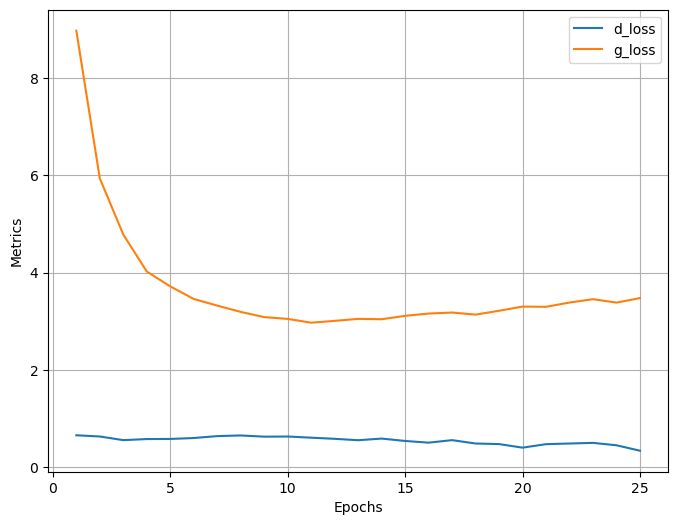

In [18]:

log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

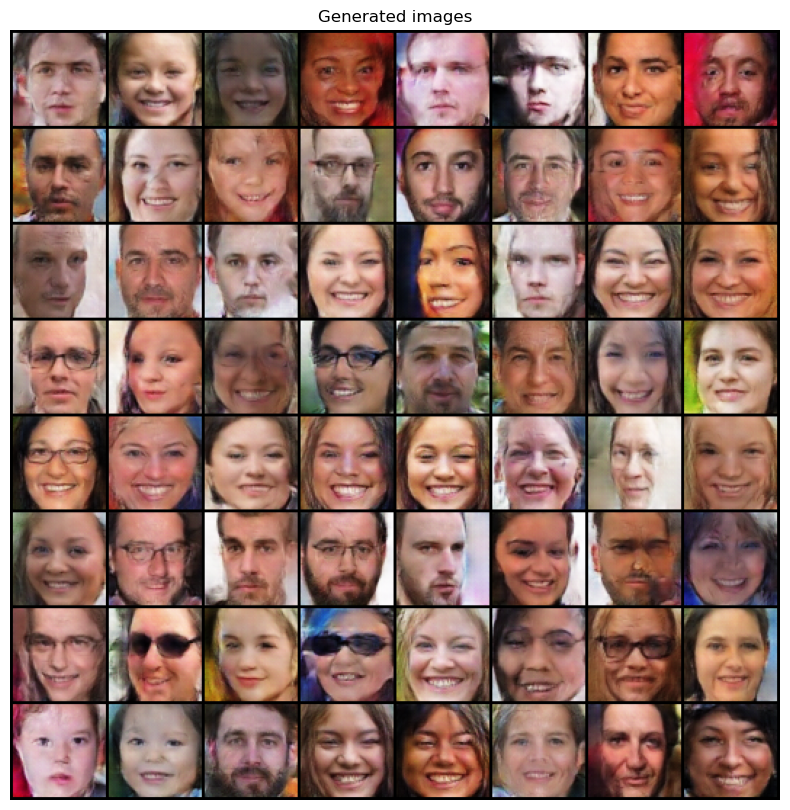

In [19]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')